In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

DATA_PATH = "../data/raw/training_data_phoenix_memory.npz"

In [4]:
data = np.load(DATA_PATH)
X = data["X"]
y = data["y"]

columns = [
    "S0", "r", "sigma", "T",
    "autocall_barrier", "coupon_barrier",
    "coupon_rate", "knock_in_barrier"
]

df = pd.DataFrame(X, columns=columns)
df["price"] = y

print(f"Loaded dataset: {df.shape}")
df.head()

Loaded dataset: (1000, 9)


,S0,r,sigma,T,autocall_barrier,coupon_barrier,coupon_rate,knock_in_barrier,price
0,100.0,0.034118,0.116146,1.050900,1.009219,0.676386,0.115401,0.681209,1.026903
1,100.0,0.013829,0.345926,2.724732,1.025649,0.686745,0.072826,0.682424,0.948888
2,100.0,0.037073,0.288982,2.818518,1.011595,0.769869,0.073893,0.651817,0.964858
3,100.0,0.008295,0.249337,1.956812,1.009217,0.652234,0.103695,0.647113,1.015962
4,100.0,0.045930,0.287660,2.792806,1.043235,0.682721,0.103845,0.686613,0.979940


In [5]:
display(df.describe().T)

print("\n--- Target Variable ---")
print(f"Mean price: {df['price'].mean():.4f}")
print(f"Std dev: {df['price'].std():.4f}")
print(f"Min/Max: {df['price'].min():.4f} / {df['price'].max():.4f}")

,count,mean,std,min,25%,50%,75%,max
S0,1000.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
r,1000.0,0.024938,0.014459,0.000051,0.012468,0.025354,0.037333,0.049980
sigma,1000.0,0.248010,0.085672,0.100572,0.176326,0.248723,0.317013,0.399514
T,1000.0,1.737679,0.721975,0.501166,1.128908,1.712320,2.350840,2.997079
autocall_barrier,1000.0,1.023761,0.014029,1.000001,1.011485,1.023484,1.035275,1.049980
coupon_barrier,1000.0,0.723181,0.042407,0.650040,0.687956,0.722175,0.760331,0.799978
coupon_rate,1000.0,0.089989,0.017305,0.060094,0.075139,0.090695,0.104356,0.119931
knock_in_barrier,1000.0,0.650263,0.028277,0.600244,0.626066,0.650612,0.674846,0.699919
price,1000.0,1.001878,0.028391,0.927037,0.981723,1.003808,1.020567,1.103538



--- Target Variable ---
Mean price: 1.0019
Std dev: 0.0284
Min/Max: 0.9270 / 1.1035


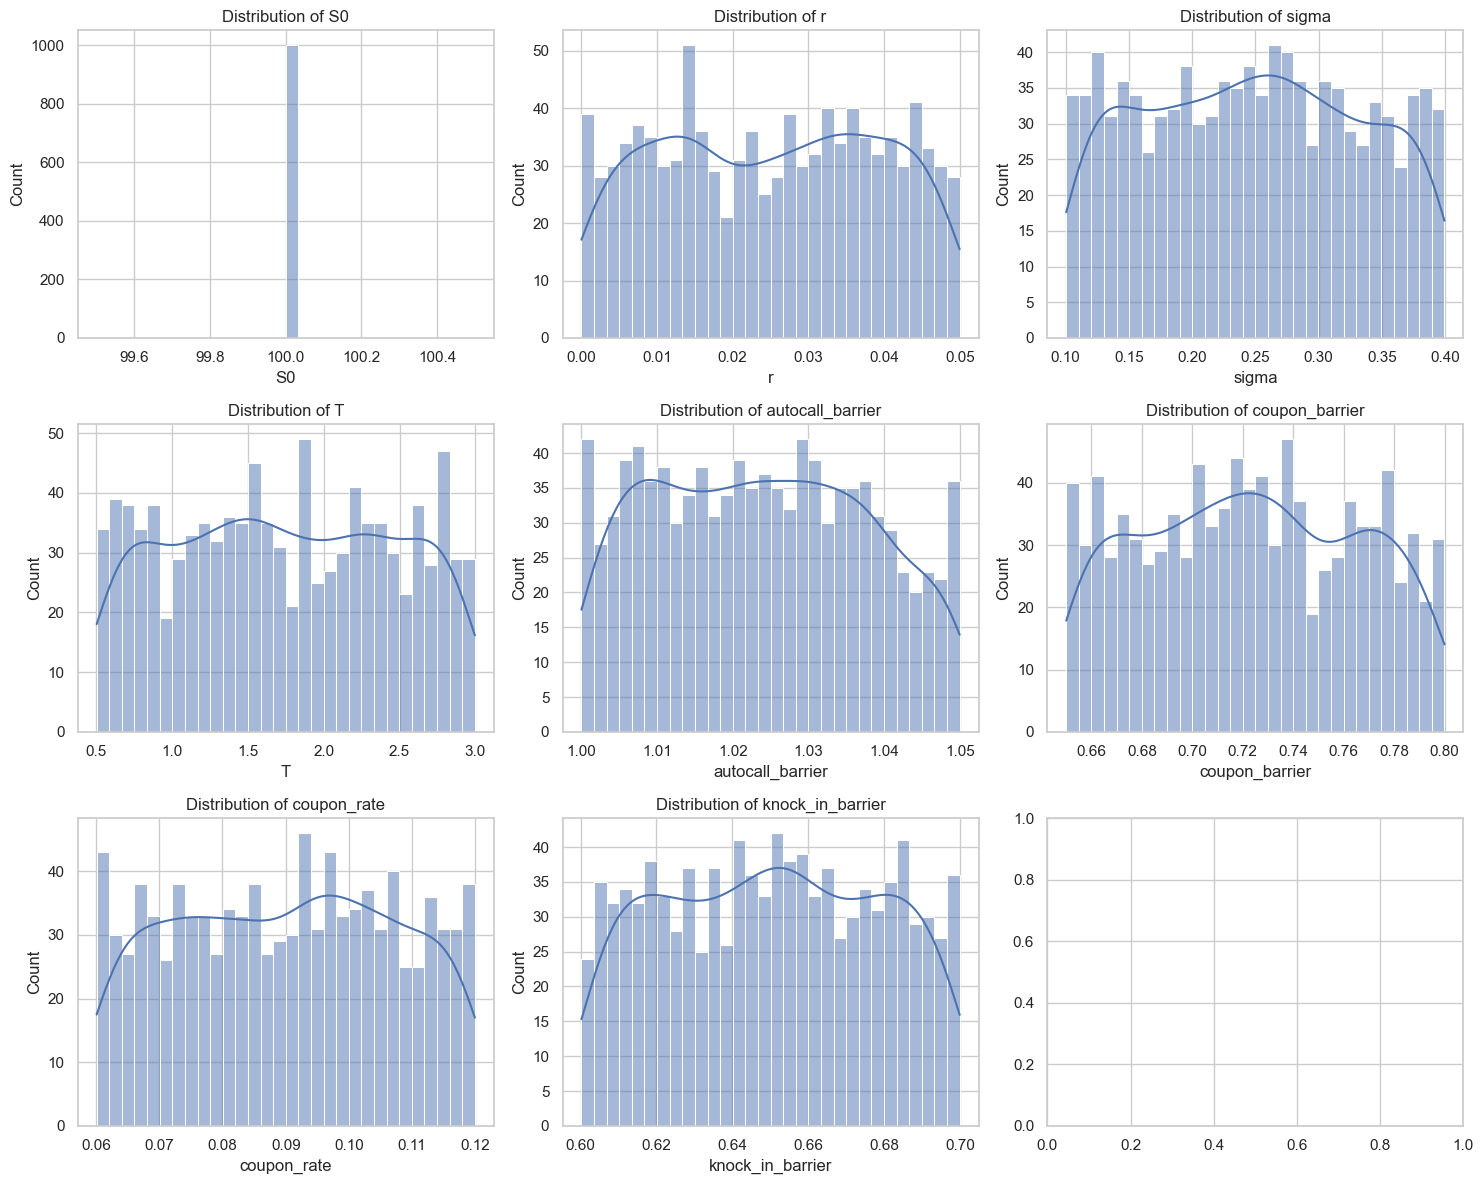

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

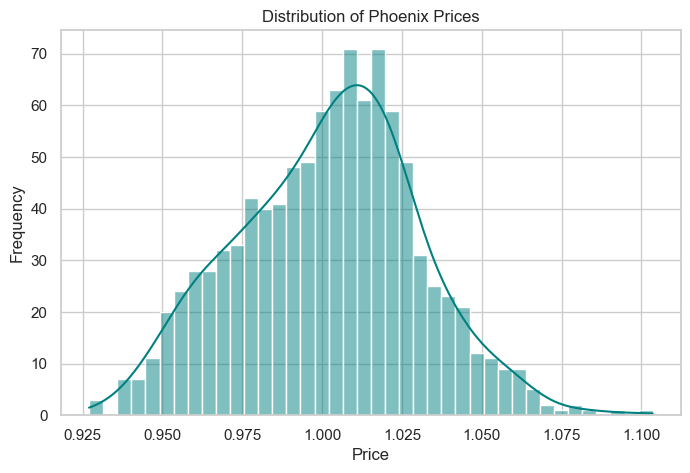

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df["price"], bins=40, kde=True, color="teal")
plt.title("Distribution of Phoenix Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

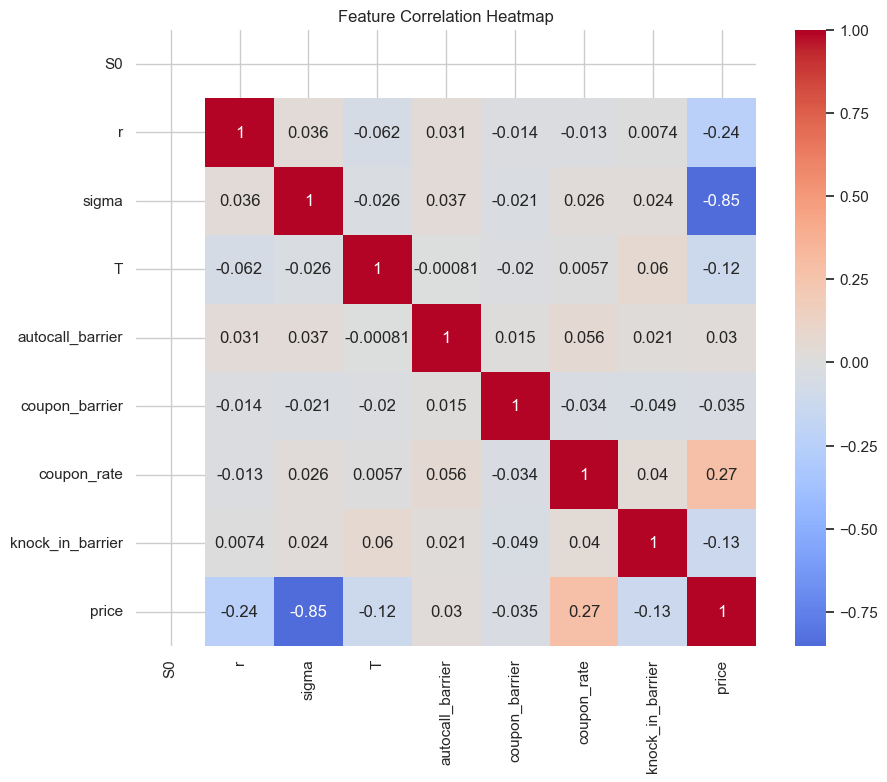

In [8]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

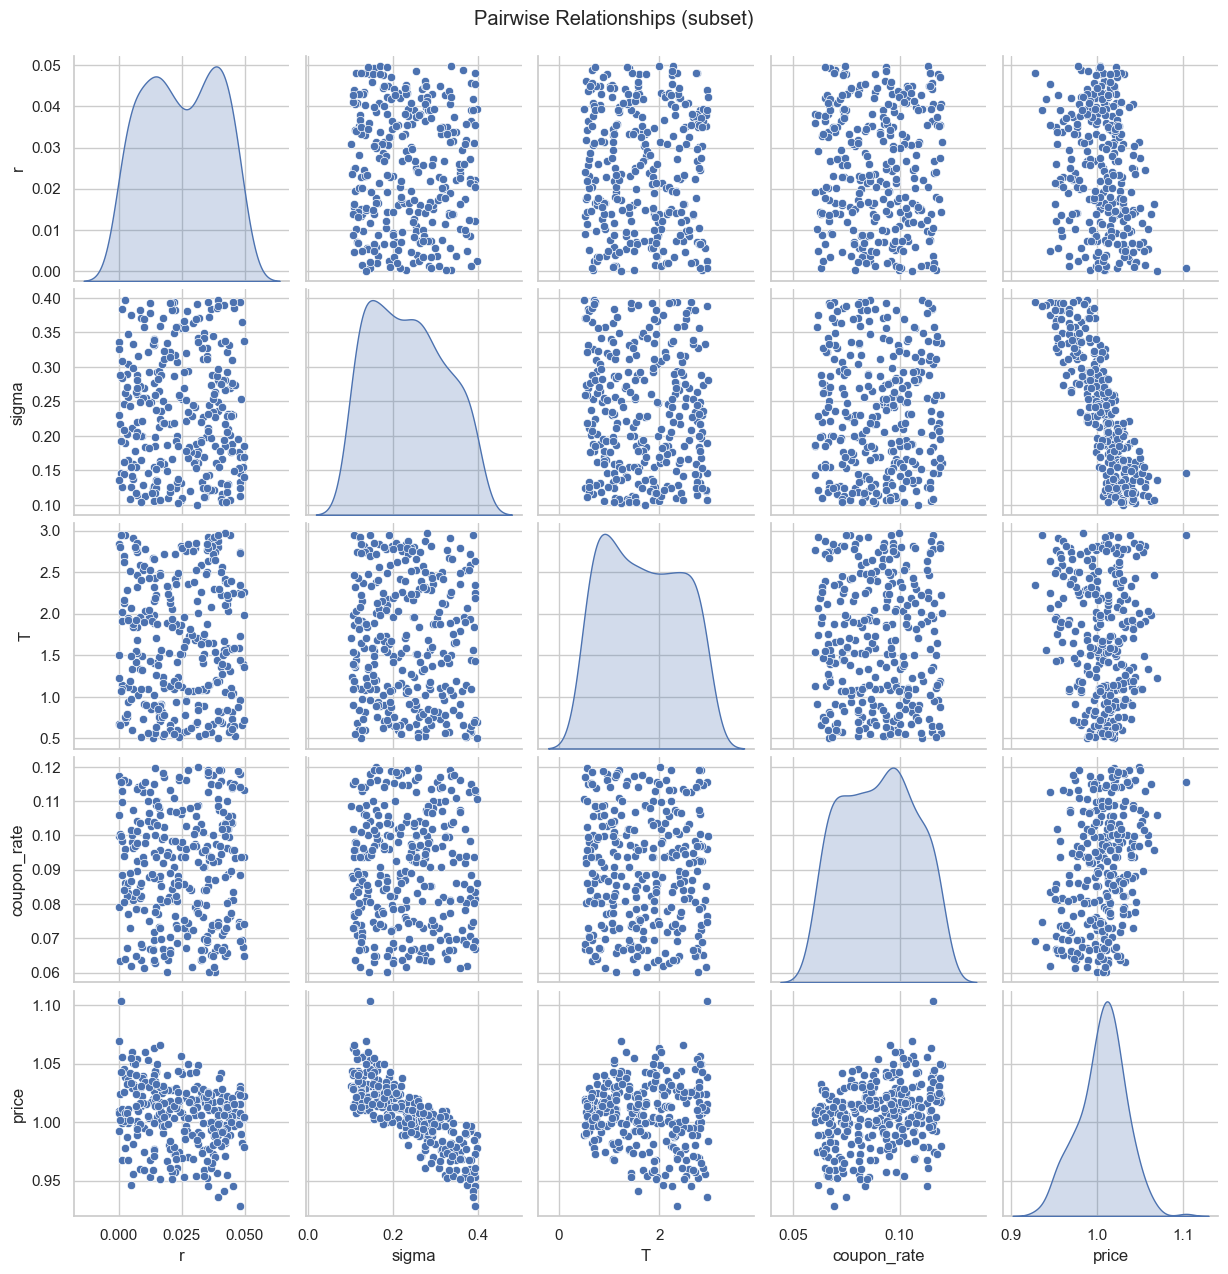

In [ ]:
sampled_df = df.sample(n=min(300, len(df)), random_state=42)
sns.pairplot(sampled_df, vars=["r", "sigma", "T", "coupon_rate", "price"], diag_kind="kde")
plt.suptitle("Pairwise Relationships (subset)", y=1.02)
plt.show()

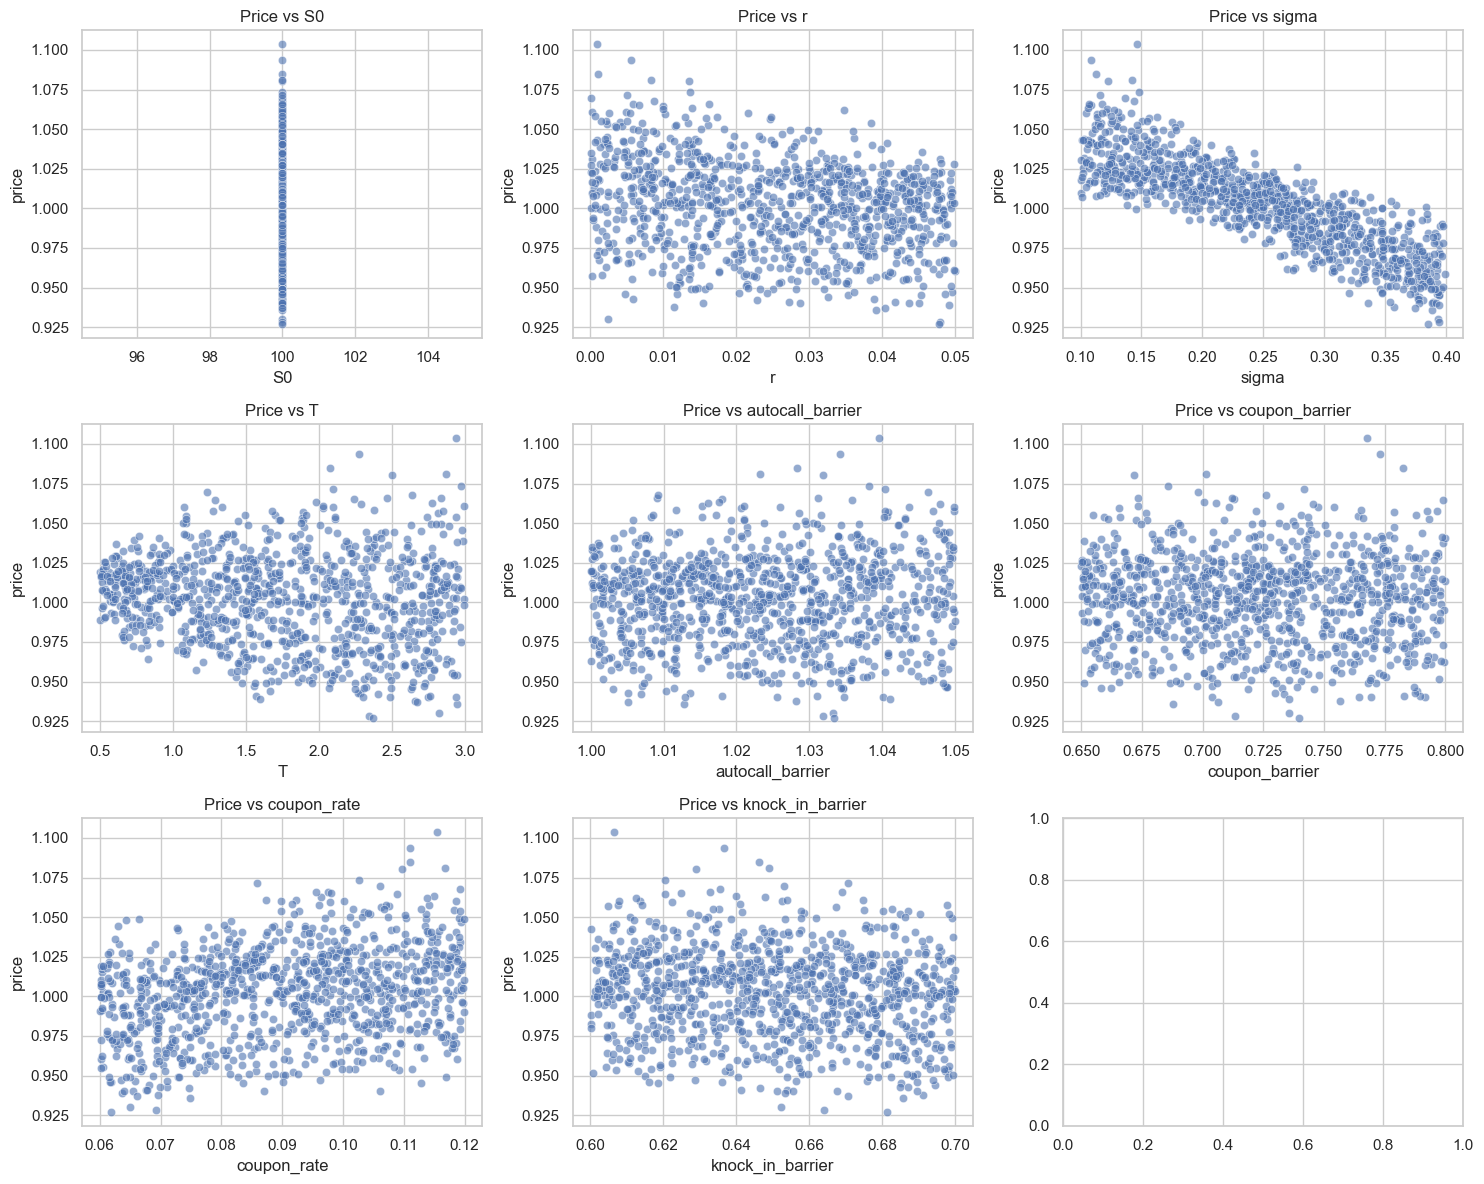

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):
    sns.scatterplot(x=df[col], y=df["price"], ax=axes[i], alpha=0.6)
    axes[i].set_title(f"Price vs {col}")

plt.tight_layout()
plt.show()

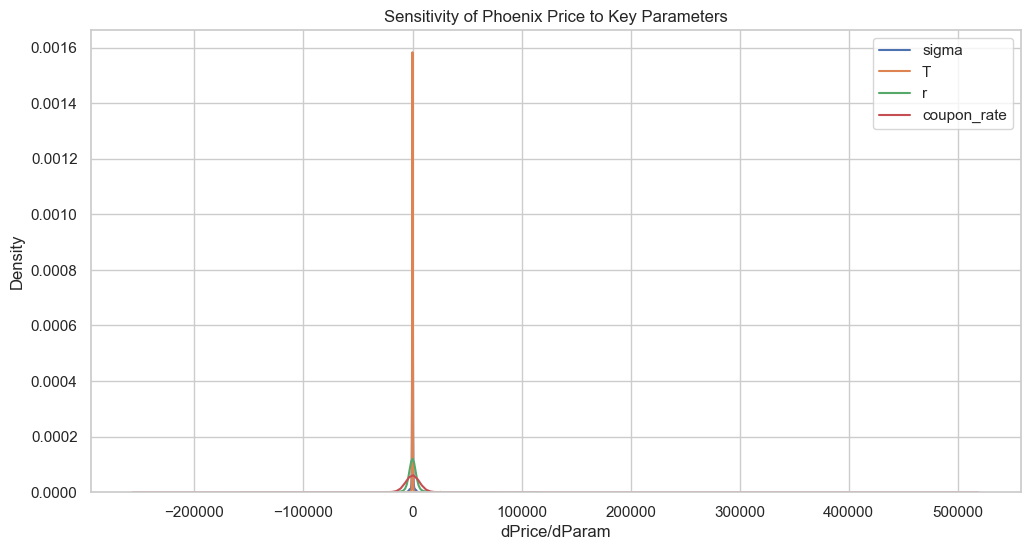

In [11]:
# Sort by feature, take finite differences
def sensitivity(df, feature):
    df_sorted = df.sort_values(feature)
    diff_x = np.diff(df_sorted[feature])
    diff_y = np.diff(df_sorted["price"])
    grad = diff_y / np.where(diff_x == 0, np.nan, diff_x)
    return pd.Series(grad, name=f"dPrice/d{feature}")

plt.figure(figsize=(12,6))
for feature in ["sigma", "T", "r", "coupon_rate"]:
    grad = sensitivity(df, feature)
    sns.kdeplot(grad.dropna(), label=feature)
plt.title("Sensitivity of Phoenix Price to Key Parameters")
plt.xlabel("dPrice/dParam")
plt.legend()
plt.show()

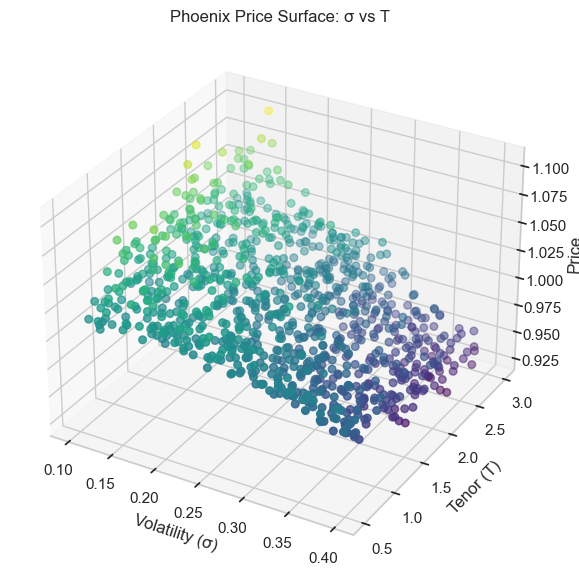

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df["sigma"], df["T"], df["price"], c=df["price"], cmap="viridis", s=30)
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Tenor (T)")
ax.set_zlabel("Price")
ax.set_title("Phoenix Price Surface: σ vs T")
plt.show()

In [13]:
out_path = "../data/processed/phoenix_eda_summary.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df.describe().to_csv(out_path)
print(f"Summary stats saved to {out_path}")

Summary stats saved to ../data/processed/phoenix_eda_summary.csv
